# Data Analysis

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
pathtohere = Path()

In [2]:
fineStructure = 1. / 137. ## Cite a better value for this.
LHC_s = (7e+3)**2 # [GeV^2] ## Cite a better value of this from  the W boson ATLAS paper. 
CKM = np.asarray([[0.97373, 0.2243, 0.00382], [0.221, 0.975, 0.0408], [0.0086, 0.0415, 1.014]]) ## Again cite
fermiConstant = 1.1663787e-5 # Cite
sin2WeinbergAngle = 0.22290 # Cite

In [3]:
def read_parameterFile():
    """
    Read variables from parameter file and extract useful quantities.
    
    Outputs:
        - LHC_s:float: CoM squared energy.
        - m_W:float: Mass of W boson used.
        - m_Z:float: Mass of Z boson used.
        - Qs:np.ndarray: Q^2 values used.
    """
    
    with open(pathtohere / 'data/parameterFile.txt') as f:
        while line:=f.readline():
            thisLine = line.rstrip().split(' ')
            if thisLine[0]=='s':
                LHC_s = float(thisLine[-1])
            elif thisLine[0]=='m_W':
                m_W = float(thisLine[-1])
            elif thisLine[0]=='m_Z':
                m_Z = float(thisLine[-1])
            elif thisLine[0]=='Qmin':
                Qmin = float(thisLine[-1])
            elif thisLine[0]=='Qmax':
                Qmax = float(thisLine[-1])
            elif thisLine[0]=='numQ':
                numQ = int(thisLine[-1])
                
    Qs = np.linspace(Qmin, Qmax, numQ)
    
    return LHC_s,m_W,m_Z,Qs
                


def read_data(file:str, m_W:float, m_Z:float, Qs:np.ndarray):
    """
    Read a given data file.
    
    Inputs:
        - file:str: Filename.
        - m_W:float: Mass of W boson used.
        - m_Z:float: Mass of Z boson used.
        - Qs:np.ndarray: Q^2 values used.
        
    Outputs:
        - xs:np.ndarray: Momentum fractions.
        - data:np.ndarray: PDFs. (Q^2,x,flavour)
        - qs:np.ndarray: Q^2 used.
    """
    
    # Get data from file for x1.
    data_all = np.loadtxt(pathtohere / file, dtype=str)
    whereNan = np.where('-nan(ind)'==data_all)
    data_all[whereNan] = '0.'
    data_all = data_all.astype(float)
    
    # Split into different Q^2
    qs = np.concatenate((np.asarray([m_W,m_Z]), Qs))
    numQ = int(qs.shape[0])
    numX = int(data_all.shape[0]/numQ)
    data = np.empty((numQ,numX,data_all.shape[1]),dtype=float)
    for i in range(numQ):
        data[i,:,:] = data_all[i*numX:(i+1)*numX]
        
    xs = data[:,:,0]

    
    data = data[:,:,1:]
    
    return xs, data, qs


In [4]:
def display_PDFs(xs:np.ndarray, data:np.ndarray, headings:tuple,colours:tuple,q:float, momFrac:int):
    """
    Display the PDFs.
    
    Inputs:
        - xs:np.ndarray: Momentum fractions the PDFs are evaluated at.
        - data:np.ndarray: 2D array of PDFs of each used quark at all x.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - q:float: Q evaluated at.
        - momFrac:int: Momentum fraction index 1/2.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    divider = 1.
    
    for i,heading in enumerate(headings):
        if '/' in heading:
            divider = float(heading.split('/')[1])
        ax.plot(xs, data[:, i] / divider, label=heading,c=colours[i],marker='.')
        ax.grid()
    
    # Create appropiate labels.
    ax.set_xlabel(f'momentum fraction / x_{momFrac}')
    ax.set_ylabel(r'PDF / $f_i(x)$')
    ax.set_title(r'$Q$ =' + str(q))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()
    
    
    
def display_fortran_c_error(data_c:np.ndarray, data_f:np.ndarray,
                            xs:np.ndarray,headings:tuple,colours:tuple,
                           q2:float):
    """
    Error of C translated code to Fortran (hopefully zero).
    
    Inputs:
        - data_c:np.ndarray: Data obtained from C++ code.
        - data_f:np.ndarray: Data obtained from Fortran code.
        - xs:np.ndarray: Momentum fraction evaluated at.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - qs:float: Q^2 evaluated at.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    
    for i,heading in enumerate(headings):
        ax.plot(xs, data_c[:, i] - data_f[:,i], label=heading,c=colours[i],marker='.')
        ax.grid()
        
    ax.axhspan(-1e-6, 1e-6,
                    alpha=0.2, color='r')
    
    # Create appropiate labels.
    ax.set_xlabel('momentum fraction / x')
    ax.set_ylabel(r'PDF difference / $\Delta f_i(x)$')
    ax.set_title(r'$Q^2$ =' + str(q2))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()

In [8]:
class CrossSection:
    numUpType = 2
    upCharge = 2. / 3.
    numDownType = 3
    downCharge = -1./3.
    numColours:int = 3
    
    upType_i = slice(0,2)
    downType_i = slice(2,5)
    upTypeBar_i = slice(5,7)
    downTypeBar_i = slice(7,10)
    
    
    
    def __init__(self, WmassSqrd:float, ZmassSqrd:float,
                 data1:np.ndarray, data2:np.ndarray,x1:np.ndarray,
                 x2s:np.ndarray,qs:np.ndarray,W_index:int,
                 Z_index:int):
        """
        Initialise the class.
        
        Inputs:
            - WmassSqrd:float: Squared mass of the W boson.
            - ZmassSqrd:float: Squared mass of the Z boson.
            - data1:np.ndarray: PDFS associated with x1 (Q, x, PDF).
            - data2:np.ndarray: PDFS associated with x2 (Q, x, PDF).
            - x1:np.ndarray: Momentum fractions for proton 1.
            - x2s:np.ndarray: Momentum fractions for proton 2 at all Q.
            - qs:np.ndarray: Qs evaluated at.
            - W_index:int: Index of data for the W boson Q.
            - Z_index:int: Index of data for the Z boson Q.
        """
                 
        self.WmassSqrd = WmassSqrd
        self.ZmassSqrd = ZmassSqrd
        self.data = np.asarray((data1,data2))
        self.x1 = x1
        self.x2s = x2s
        self.numX = x1.shape[0]
        self.qs = qs[2:]
        self.numQ = qs.shape[0] - 2
        self.W_index = W_index
        self.Z_index = Z_index
        self.sigma0 = 4.*np.pi*fineStructure*fineStructure / (3.*qs*qs)
        
        self.photon_dydm = None
        self.photon_dm = None
        self.W_dy = None
        self.Z_dy = None

    
    
    
### W stuff #####################################################################
    def calculate_W_dy(self):
        """
        Calculate the W boson contribution to the cross section.
        """

        upTypePDFs = self.data[:,self.W_index,:,self.upType_i]
        downTypePDFs = self.data[:,self.W_index,:,self.downType_i]
        upTypeBarPDFs = self.data[:,self.W_index,:,self.upTypeBar_i]
        downTypeBarPDFs = self.data[:,self.W_index,:,self.downTypeBar_i]
        

        
        self.W_dy = np.zeros(self.numX)
        for i in range(self.numUpType):
            for j in range(self.numDownType):
                poisson = np.zeros(self.numX)
                for k in range(2):
                    poisson += upTypePDFs[k,:,i] * downTypeBarPDFs[1-k,:,j]

                self.W_dy += CKM[i,j]*CKM[i,j] * poisson

        self.W_dy *= np.pi/self.numColours*np.sqrt(2.) * fermiConstant*self.WmassSqrd
        self.W_dy /= LHC_s


    def calculate_W(self):
        """
        Integrate W contribution over rapidity.
        """
        
        if self.W_dy is None:
            self.calculate_W_dy()
        
        self.rapidities_W = 0.5 * np.log(self.x2s[self.W_index] / self.x1)

        
        # Integrate over rapidity.
        integral = np.sum((self.W_dy[:-1] + self.W_dy[1:])*(self.rapidities_W[:-1] - self.rapidities_W[1:]) / 2.)
        integral *= 1e+9*0.3894 # [GeV^-2 -> pb]
        print(f'W contribution: {integral} [pb]')
        
        return integral
    
### Z stuff ###############################################################
    def calculate_Z_dy(self):
        """
        Calculate the Z boson contribution to the cross section.
        """

        
        upTypePDFs = self.data[:,self.Z_index,:,self.upType_i]
        downTypePDFs = self.data[:,self.Z_index,:,self.downType_i]
        upTypeBarPDFs = self.data[:,self.Z_index,:,self.upTypeBar_i]
        downTypeBarPDFs = self.data[:,self.Z_index,:,self.downTypeBar_i]

        
        self.Z_dy = np.zeros(self.numX)

        # Up-type.
        V_q = 0.5 -2.*self.upCharge*sin2WeinbergAngle
        A_q = 0.5
        poisson = np.zeros(self.numX)
        for i in range(2):
            poisson += np.sum(upTypePDFs[i] * upTypeBarPDFs[1-i], axis=1)
        self.Z_dy += (V_q*V_q + A_q*A_q)*poisson*self.upCharge*self.upCharge
        

        # Down-type.
        V_q = -0.5 - 2.*self.downCharge*sin2WeinbergAngle
        A_q = -0.5
        poisson = np.zeros(self.numX)
        for i in range(2):
            poisson += np.sum(downTypePDFs[i] * downTypeBarPDFs[1-i], axis=1)
        self.Z_dy += (V_q*V_q + A_q*A_q)*poisson*self.downCharge*self.downCharge

        self.Z_dy *= np.pi/self.numColours*np.sqrt(2.) * fermiConstant*self.ZmassSqrd
        
        
    def calculate_Z(self):
        """
        Integrate Z contribution over rapidity.
        """
        
        if self.Z_dy is None:
            self.calculate_Z_dy()

        self.rapidities_Z = 0.5 * np.log(self.x2s[self.Z_index] / self.x1)

        
        # Perform integration over rapidity.
        integral = np.sum((self.Z_dy[:-1] + self.Z_dy[1:])*(self.rapidities_Z[:-1] - self.rapidities_Z[1:]) / 2.)
        integral /= LHC_s
        integral *= 1e+9*0.3894 # [GeV^-2 -> pb]
        print(f'Z contribution: {integral} [pb]')
        
        return integral
    
    
    
        
### Photon stuff ##################################################################################
    def calculate_photon_dydm(self):
        """
        Calculate photon contribution to the cross section.
        """
        
            
        #include = np.argwhere


        upTypePDFs = np.delete(self.data[:,:,:,self.upType_i], (self.W_index,self.Z_index),1)
        downTypePDFs = np.delete(self.data[:,:,:,self.downType_i], (self.W_index,self.Z_index),1)
        upTypeBarPDFs = np.delete(self.data[:,:,:,self.upTypeBar_i], (self.W_index,self.Z_index),1)
        downTypeBarPDFs = np.delete(self.data[:,:,:,self.downTypeBar_i], (self.W_index,self.Z_index),1)
        
        
        
        # Photon
        self.photon_dydm = np.zeros((self.numQ,self.numX))
        for i in range(2):
            self.photon_dydm += self.upCharge*self.upCharge * np.sum(upTypePDFs[i] * upTypeBarPDFs[1-i], axis=2)
            self.photon_dydm += self.downCharge*self.downCharge * np.sum(downTypePDFs[i] * downTypeBarPDFs[1-i], axis=2)

            
        self.photon_dydm *= self.sigma0[2:,None] / (LHC_s * self.numColours)
        
    
    def calculate_photon_dm(self):
        """
        Integrate photon contribution over rapidity.
        """
        
        if self.photon_dydm is None:
            self.calculate_photon_dydm()
        
        ## The 2: slice here needs to be changed using np.argwhere.
        rapidities = 0.5*np.log(self.x2s[2:] / self.x1)
        
        
        # Integrate over rapidity.
        self.photon_dm = np.sum((self.photon_dydm[:,:-1] + self.photon_dydm[:,1:])
                                *(rapidities[:,:-1] - rapidities[:,1:]) / 2., axis=1)
        
    def calculate_photon(self):
        """
        Integrate photon contribution over mass.
        """
        
        if self.photon_dm is None:
            self.calculate_photon_dm()
            
        
        # Integrate over mass.
        integral = np.sum((self.photon_dm[:-1] + self.photon_dm[1:]) * (self.qs[1:] - self.qs[:-1]) / 2.)
        integral *= 1e+9*0.3894 # [GeV^-2 -> pb]
        print(f'Photon contribution: {integral} [pb]')
        
        return integral
    
    def display_photon_dm(self):
        """
        Display how the photon cross section contribution varies with the Q^2.
        """
        
        if self.photon_dm is None:
            raise Exception('calculate_photon_dm() has not been called.')
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.qs*self.qs, self.photon_dm)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel('Q^2')
        ax.set_ylabel(r'$\frac{d\sigma}{dm^2}$')
        ax.set_title(r'$\gamma$')
        
        plt.show()
        
    def display_W_dy(self):
        """
        Display how the W cross section contribution varies with rapidity.
        """
        
        if self.W_dy is None:
            raise Exception('calculate_W_dy() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.rapidities_W, self.W_dy)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'rapidity / $\eta$')
        ax.set_ylabel(r'$\frac{d\sigma}{dy}$')
        ax.set_title('W')
        
        plt.show()
        
    def display_Z_dy(self):
        """
        Display how the Z cross section contribution varies with rapidity.
        """
        
        if self.W_dy is None:
            raise Exception('calculate_Z_dy() has not been called.')
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.rapidities_Z, self.Z_dy)
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(r'rapidity / $\eta$')
        ax.set_ylabel(r'$\frac{d\sigma}{dy}$')
        ax.set_title('Z')
        
        plt.show()
        

In [9]:
def main():
    LHC_s,m_W,m_Z,Qs = read_parameterFile()
    
    x1s, data1, qs = read_data('data/PDF1.out', m_W,m_Z,Qs)
    x2s, data2, __ = read_data('data/PDF2.out', m_W,m_Z,Qs)
    
    
    
#     # Get Fortran data for error comparison (bug detection).
#     data_all_f = np.loadtxt(pathtohere / 'data/partonfrac_f.out',dtype=str)
#     whereNan = np.where('NaN'==data_all_f)
#     data_all_f[whereNan] = '0.'
#     data_all_f = data_all_f.astype(float)
    
#     # Split into different Q^2
#     data_f = np.empty((numQ,numX,data_all_f.shape[1]),dtype=float)
#     for i in range(numQ):
#         data_f[i,:,:] = data_all_f[i*numX:(i+1)*numX]
#     data_f = data_f[:,:,1:]

    
    headings = ('up','down','charm', 'strange','bottom','ubar','dbar','cbar',
                'sbar','bbar','g/10')
    colours = ('r','g','orange','b','k','c','y','pink','m','purple','lime')
    
    W_index = 0
    Z_index = 1
    crossSection = CrossSection(m_W*m_W, m_Z*m_Z,data1,data2,x1s[0],x2s,qs,W_index,Z_index)
    crossSection.calculate_W()
    crossSection.calculate_Z()
    crossSection.calculate_photon()
    
    crossSection.display_photon_dm()
    crossSection.display_W_dy()
    crossSection.display_Z_dy()
    
    
    
    for i in range(qs.shape[0]):
        pass
        display_PDFs(x1s[i],data1[i],headings,colours,qs[i], 1)
        display_PDFs(x2s[i],data2[i],headings,colours,qs[i], 2)
        # display_PDFs(x1s[i],data1[i]*x1s[i,:,None],headings,colours,qs[i], 1)
        # display_PDFs(x2s[i],data2[i]*x2s[i,:,None],headings,colours,qs[i], 2)
        # display_PDFs(xs,data_f[i],headings,colours,qs[i])
        
        # display_fortran_c_error(data[i],data_f[i],xs,headings,colours,qs[i])
        
        
    
        
    

    
    
    

W contribution: 6.6536949214787775 [pb]
Z contribution: 1.3988569047909227 [pb]
Photon contribution: 4.11245372474449e-05 [pb]


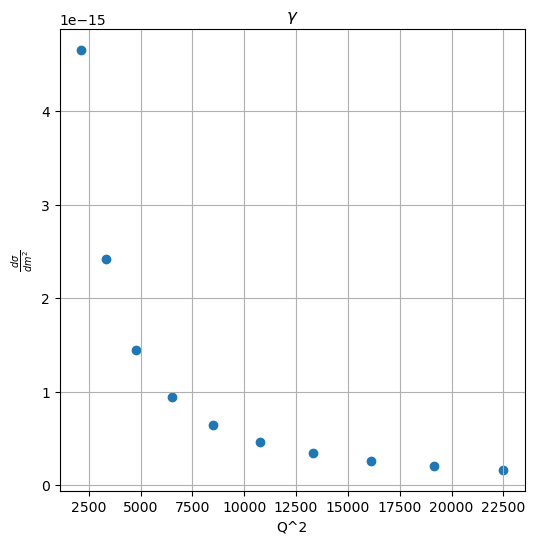

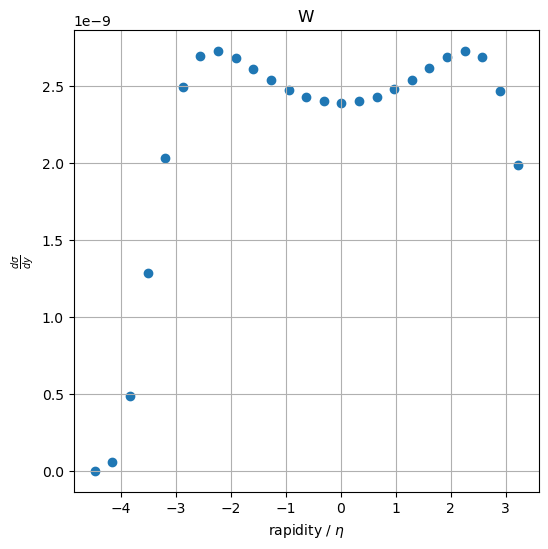

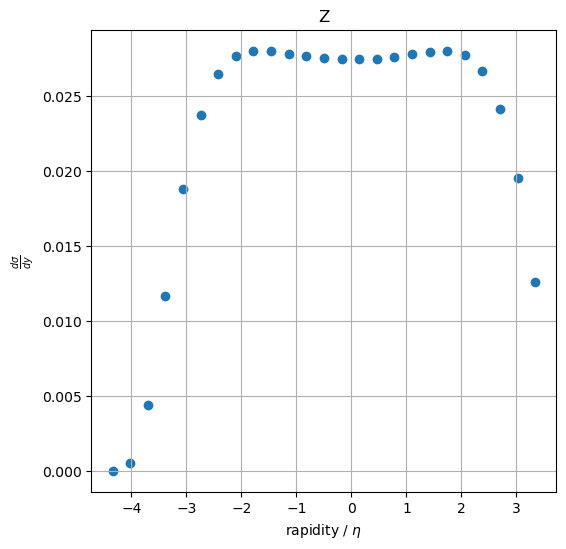

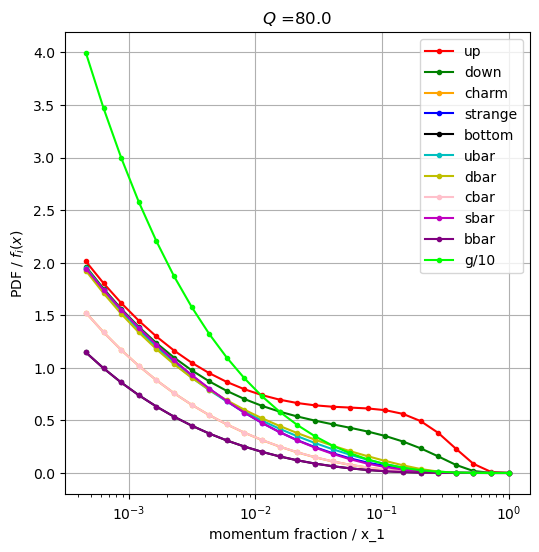

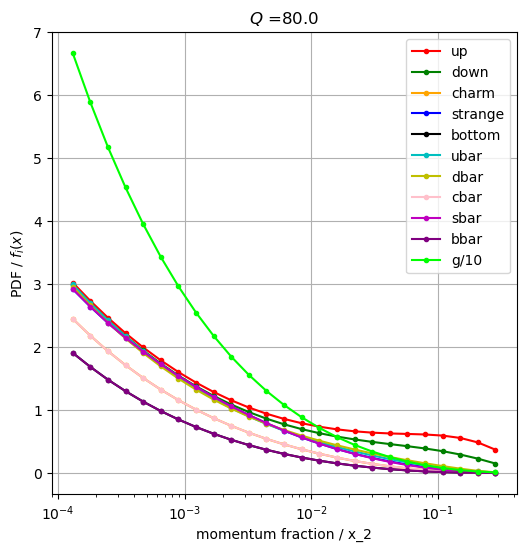

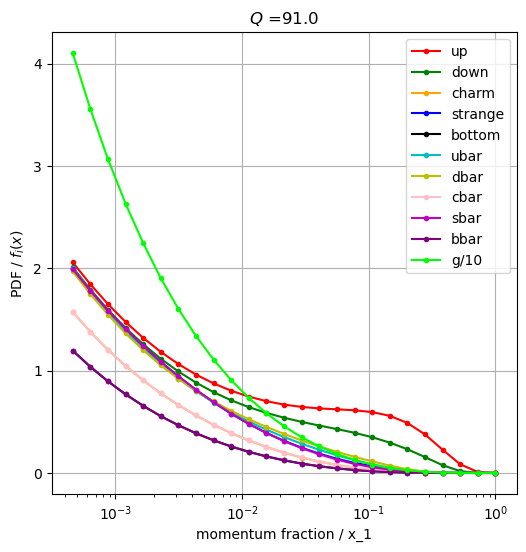

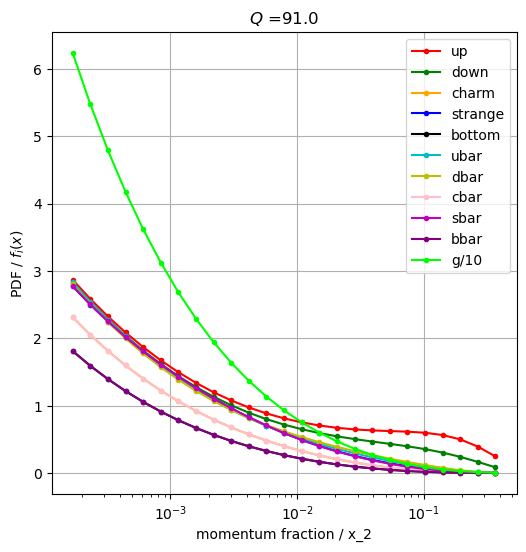

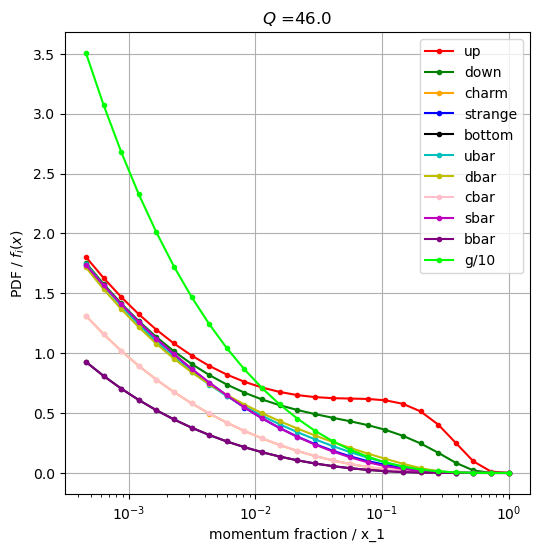

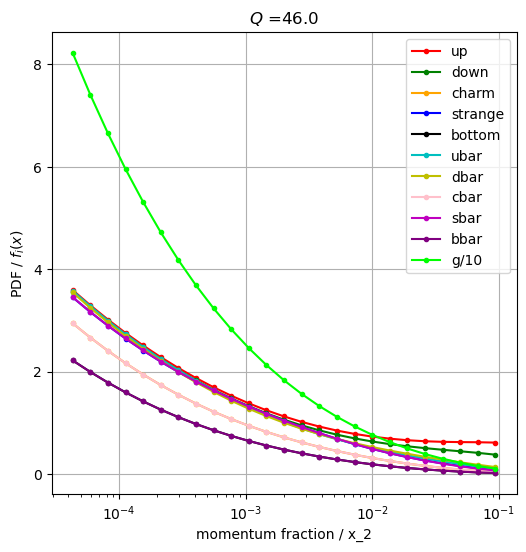

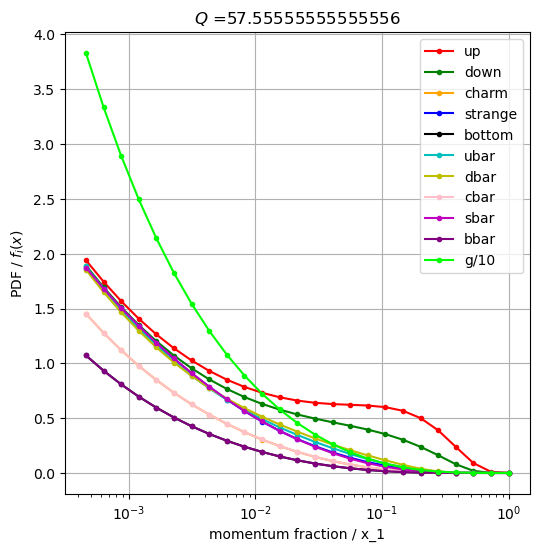

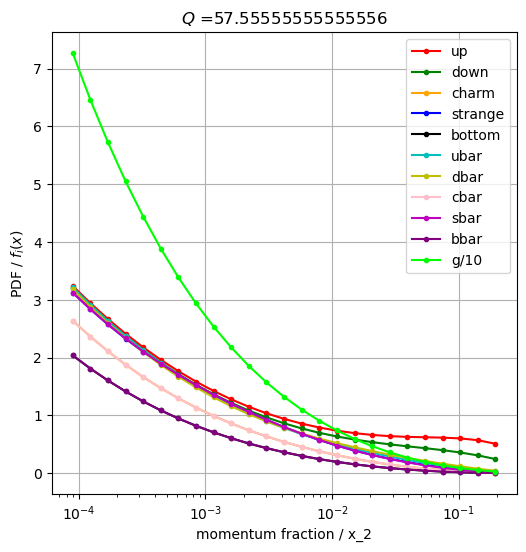

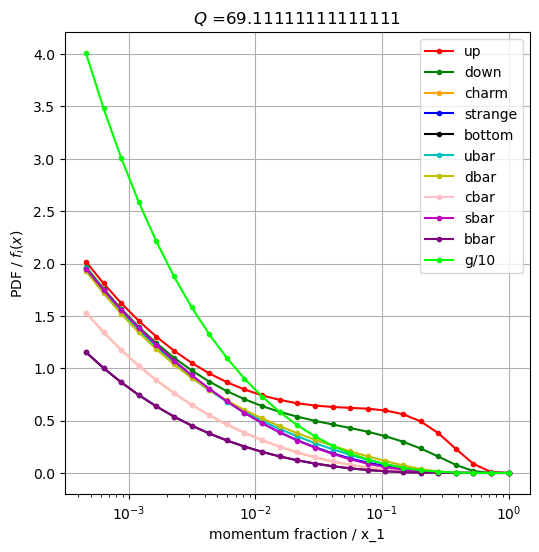

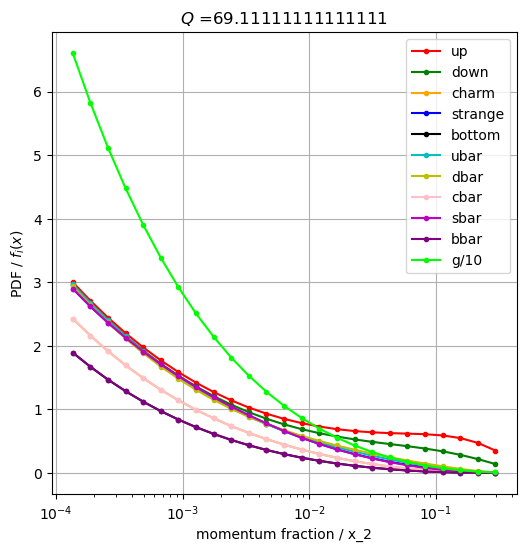

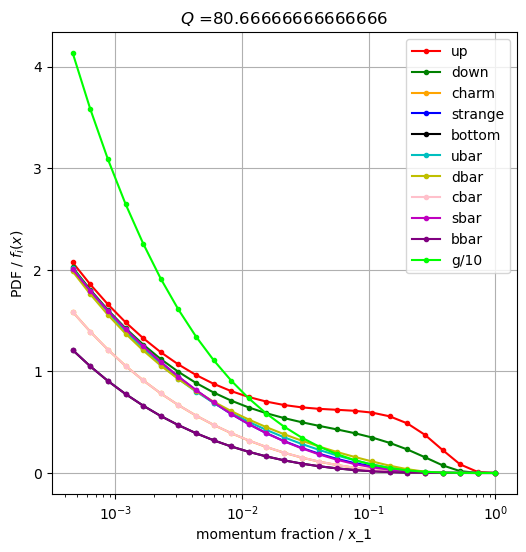

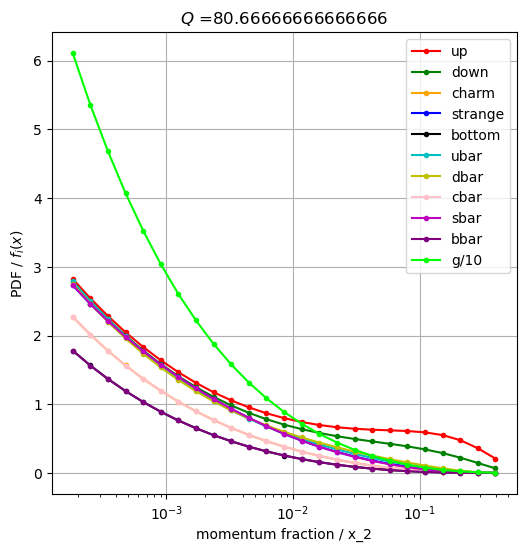

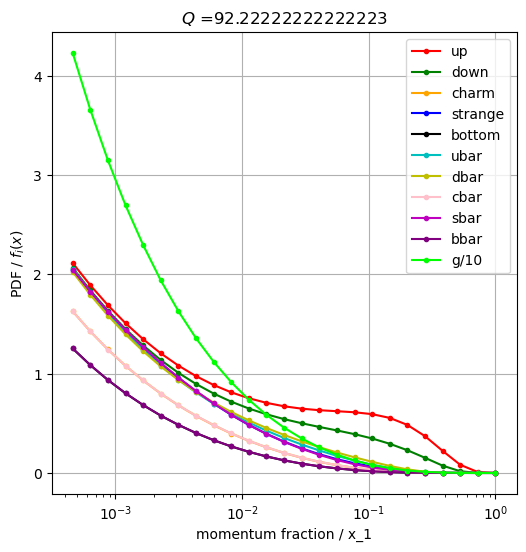

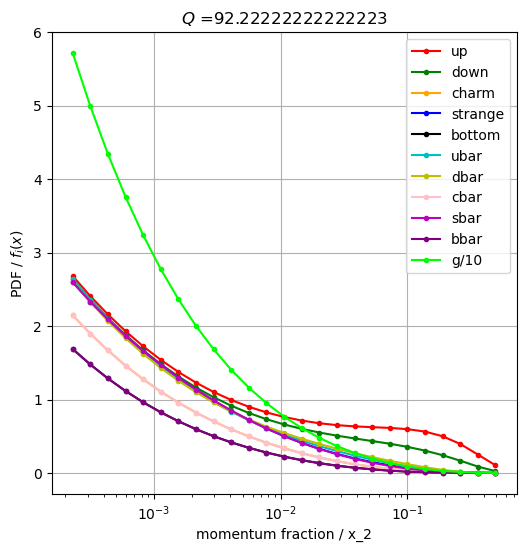

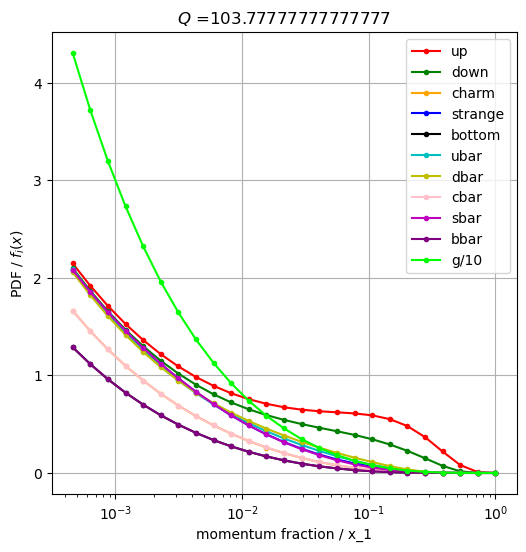

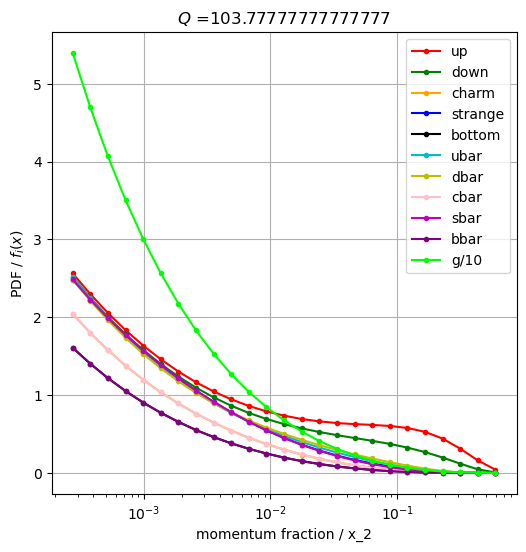

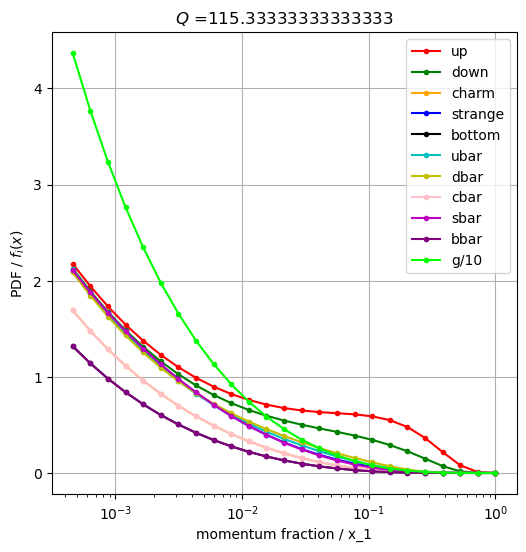

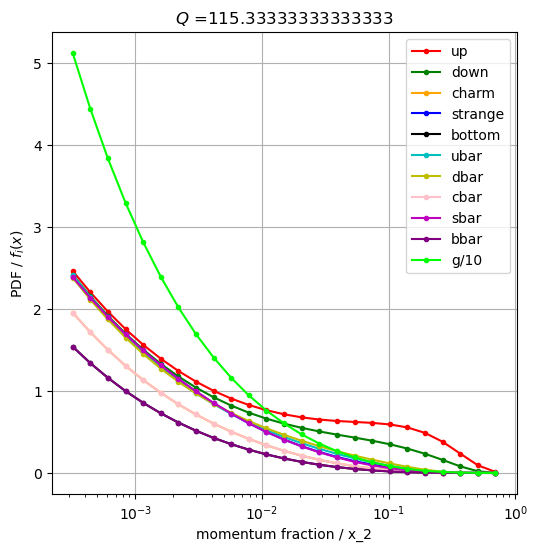

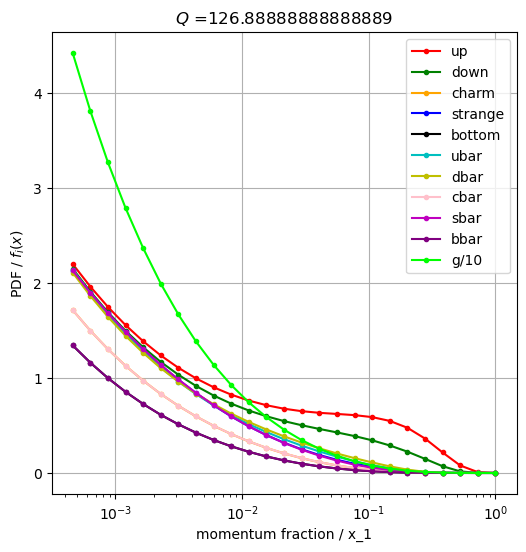

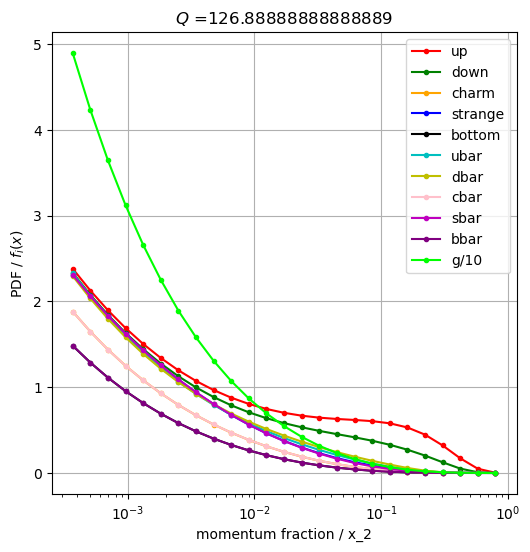

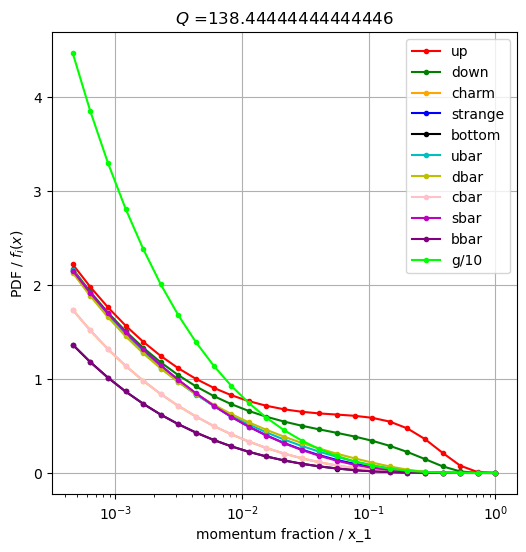

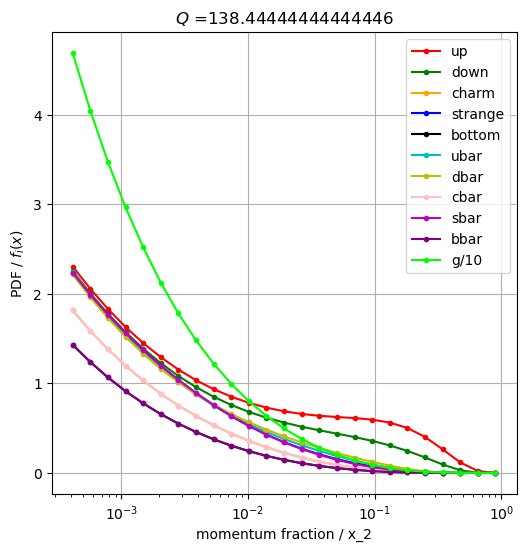

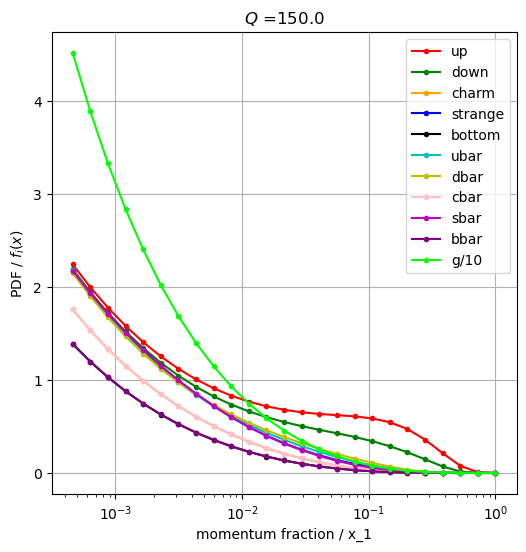

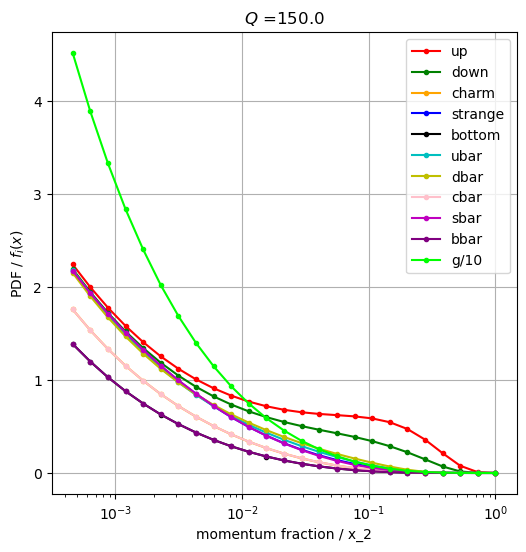

In [10]:
if __name__=='__main__':
    main()